# Duplicate Dataset Analysis

In this notebook we'll provide a comprehensive comparison of repetitiveness of URL usage in open and commonly used datasets on the literature. This was motivated by **lack of good generalization state-of-the-art** models seem to have, as documented in Fariza Rashid et al., models tested on different sources from the one they were trained on (which is a very important test for deployment reliability) have very high metric drops (ranging from 10 to 30\% drops!).

These causes are well documented by Fariza Rashid et al., even suggestion few-shot LLM approaches to tackle the phishing URL problem in a more generalizable (and as a bonus more explainable) way.

## Work Contribution

**1)** We start off by providing a comprehensive discussion of key problems regarding popular openly available datasets cited in the literature:
  - Presentation of the most popular curated phishing URL datasets
  - Dataset Problems: Duplicates and Contradictory URLs Internally in Each Dataset or upon Merging (In dataset Pair Merge, Triple Merge, ...)
  - Discussion: how to deal with this, causes, ...
  
**2)** Then we proceed by:
  - Showing how easy it is for someone to claim 99.9% metrics upon train-test-splitting: implies metrics in a paper do not necessarily imply a model is better than state-of-the-art.
  - Discuss how even state-of-the-art models with the best performances drop significantly upon domain shifting (instead of train-test-splitting).

**3)** Then we continue exploring:

- Models that initially seemed worse may in terms of generalization not be so (we compare my character-level CNN with a state-of-the-art URLNet.) 

- Also it is shown that preprocessing helps significantly to tackle generalization (clean_prefixes, lower, [we did the 4 combinations, and clean_prefixes and lower activated lead to best metrics on validation]). 

- Discussion, e.g.:  This naturally reduces the training and testing accuracy, as we are inherently removing information that the model could use to learn, but raises on the other hand significant generalization gains, as the conclusions the model was taking away from the information we removed helped him for the training set, but in hindsight as seen by improved generalization it was "fake" knowledge, that served boosted the model's ability to label URLs in that domain but not in a general sense.  This is comproved by tests in other datasets, associated with other domains.

____________

**Note**: Only datasets composed of raw URLs were considered, excluding datasets that define a URL by their features (e.g. *'URL_Length'*, *'#digits'*, ...), to ensure compatibility with featureless deep learning models.


# This Notebook

In this notebook we'll focus on the second part. Let's start with the imports.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import sklearn.utils
import re

np.random.seed(42)

## **Datasets**

Let's now import all the main datasets (in the same structure) to use, citing their origin and giving a brief description of each.

**Note**: There are many independent data sources Alexa, PhishTank, OpenPhish, so it is possible for anyone to grab a subset and make their own dataset.These are pre-curated, benchmark datastes used in the literature.

### **Kaggle4S**

"Phishing and Legitimate URLs" **[1]** is the largest URL dataset documented here.  Compiled by Hari Sudhan in **2023**, it has been included in Esteban Alvarado's "4 Set Bundle" **[2]**, a compilation of datasets including phishing URLs and phishing e-mails.

In [2]:
kaggle4s = pd.read_csv('kaggle4s/url_kaggle.csv')
kaggle4s['status'] = 1-kaggle4s['status'] # no additional prep because this was the base struct with 'url', 'status'
kaggle4s['source'] = 0

print("Kaggle4S sucessfully loaded!")

Kaggle4S sucessfully loaded!


This dataset has columns *['url', 'status']*, corresponding to "URL" and "Label" respectively. For coherence this is the structure I will use for other datasets.

### **Kaggle2020**

"Phishing Site URLs" **[3]** is also a large URL dataset, one of the best rated in Kaggle, posted by Tarun Tiwari in **2020**. Used in **[4]** **[23]**.

In [3]:
kaggle2020 = pd.read_csv("kaggleIndianURL-102/phishing_site_urls.csv")
kaggle2020 = kaggle2020.rename(columns={"Label": "status", "URL": "url"})
kaggle2020['status'] = kaggle2020['status'].replace({'bad': 1, 'good': 0})
kaggle2020['source'] = 1

print("Kaggle2020 sucessfully loaded!")

Kaggle2020 sucessfully loaded!


### **Kaggle2019**

"Malicious And Benign URLs" **[5]** is another large Kaggle dataset, curated by Siddharth Kumar in **2019**. Acquired from various sources such as PhishTank, but significantly unbalanced ($77\%$ benign vs. $23\%$ phishing). Used in **[6]** **[7]** **[8]**.

In [4]:
kaggle2019 = pd.read_csv('kaggleSiddarth2019-70/urldata.csv')
kaggle2019 = kaggle2019.rename(columns={'label': 'status'})
kaggle2019['status'] = kaggle2019['result']
kaggle2019 = kaggle2019.drop(columns=['Unnamed: 0','result'])
kaggle2019['source'] = 2

print("Kaggle2019 sucessfully loaded!")

Kaggle2019 sucessfully loaded!


### **Kaggle2021**

Another dataset available in in Kaggle **[9]**. Created by Manu Siddhartha in **2021**. This URL dataset is curated from multiple sources: ISCX-URL-2016, Malware Domain Blacklist, Phishtank, PhishStorm, and Faizan's GitHub repository. URLs from these sources were merged into a single dataset containing URLs and their class types ("Benign", "Defacement", "Phishing" and "Malware" - to keep a consistent binary classification the last 3 classes are mapped to "Malicious".) 

Used in research by **[10]**.

In [5]:
kaggle2021 = pd.read_csv('kaggleManu2021-46/malicious_phish.csv')
kaggle2021 = kaggle2021.rename(columns={'type': 'status'})
kaggle2021['status'] = kaggle2021['status'].apply(lambda x: 0 if x == 'benign' else 1)
kaggle2021['source'] = 3

print("Kaggle2021 sucessfully loaded!")

Kaggle2021 sucessfully loaded!


### **Look Before you Leap**

This dataset is taken from **[11]**, available in **[12]**. Submitted in **2020**, this paper focuses on using not only the URL for classification BUT also **HTML** content. This is motivated by concerns such as the use of services that shorten URL **[13]**, such as tinyurl. This dataset provides but an *'URL.xlsx'* but also the *'HTML.xlsx'* for this exact purpose. 

In this notebook we'll only use the first, as the latter is out of scope of this work.

In [6]:
lbl = pd.read_excel('lookbe4leap/URL.xlsx')
lbl = lbl.rename(columns={"Category": "status", "Data": "url"})
lbl['status'] = lbl['status'].replace({'spam': 1, 'ham': 0})
lbl['source'] = 4

print("LBL sucessfully loaded!")

LBL sucessfully loaded!


### **EBBU2017**

Dataset used by **[14, 21, 22]**, available at **[15]**. EBBU focuses on the balance aspect of the data - phishing URLs were collected using a script to extract data from PhishTank, while legitimate URLs were sourced via Yandex Search API using high-ranking results unlikely to be malicious.

In [7]:
path_base = 'sahingoz_url/'
path_legit = path_base + 'sahingoz_legitimate_36400.json'
path_phish = path_base + 'sahingoz_phishing_37175.json'
with open(path_legit, 'r') as file:
    sh_legit = json.load(file)
    for i,el in enumerate(sh_legit):
        sh_legit[i] = [el,0]
    urls_0 = pd.DataFrame(sh_legit, columns=['url', 'status'])

with open(path_phish, 'r') as file:
    sh_phish = json.load(file)
    for i,el in enumerate(sh_phish):
        sh_phish[i] = [el,1]
    urls_1 = pd.DataFrame(sh_phish, columns=['url','status'])

ebbu = pd.concat([urls_0, urls_1], ignore_index=True)

#shuffle final result
ebbu = sklearn.utils.shuffle(ebbu, random_state=42)  
ebbu = ebbu.reset_index(drop = True)
ebbu['source'] = 5

print("EBBU2017 sucessfully loaded!")

EBBU2017 sucessfully loaded!


### **HISPAR / ISCX2016-URL**

At last, the HISPAR and ISCX2016-URL datasets were kindly provided by **Fariza Rashid** **[16]** **[17]**, made available in **[18]**

The official ISCX is a large project **[19]** but the official source provides each URL as a collection of features (incompatible with a featureless DL model).


In [8]:
############
## HISPAR ##
############

hispar_train = pd.read_csv('hispar/hp_train.csv')
hispar_test = pd.read_csv('hispar/hp_test.csv')
hispar_val = pd.read_csv('hispar/hp_valid.csv')

hispar = pd.concat([hispar_train, hispar_test, hispar_val])
hispar = hispar.drop(columns=['Unnamed: 0.1', 'index', 'Unnamed: 0'])

hispar = hispar.rename(columns={'label': 'status'})
hispar['source'] = 6

print("Hispar sucessfully loaded!")

############
### ISCX ###
############

iscx_train = pd.read_csv('iscx_url/iscx_train.csv')
iscx_test = pd.read_csv('iscx_url/iscx_test.csv')
iscx_val = pd.read_csv('iscx_url/iscx_valid.csv')


iscx = pd.concat([iscx_train, iscx_test, iscx_val])
iscx = iscx.drop(columns=['index', 'Unnamed: 0.1', 'Unnamed: 0'])
iscx = iscx.rename(columns={'label':'status'})
iscx['source'] = 7

print("ISCX sucessfully loaded!")

Hispar sucessfully loaded!
ISCX sucessfully loaded!


# **Duplicate Remover**

Before starting with any analysis, lets create an helper function to help us analyse duplicates.

In [ ]:
def resolve_duplicates(df, count = False, verbose = False, unique = False):
    """
    Resolves duplicate URLs with conflicting labels by applying a priority rule.

    Args:
        df (pd.DataFrame): The input DataFrame containing 'url' and 'status'.
        resolving strategy: Remove URLs with conflicting labels.
    
    Returns:
        pd.DataFrame: DataFrame with duplicates resolved.
    """
    conflict_counts = df.groupby('url')['status'].nunique() #count unique labels for each URL -> if ok 1, if conflicted 2. then we simply count (below) the ones with conflict_counts == 2 (>1)

    #identify conflicting URLs (those with more than one unique label!! [we could put conflict_counts == 2])
    conflicting_urls = conflict_counts[conflict_counts > 1].index
    #if verbose: print(f"conflicting_urls = {conflicting_urls}")

    l1 = len(df)

    #remove conflicting URLs!!!
    df = df[~df['url'].isin(conflicting_urls)]

    l2 = len(df)
    
    if verbose == True:
        print(f"Found {l1 - l2} entries to remove and ({len(conflicting_urls)} unique conflicting URLs).")

    if count == True:
        return l1-l2
    
    if unique == True:
        return len(conflicting_urls)
    
    return df


Lets see a small test to see it works:

In [ ]:
#example: Dummy DataFrame
data = {
    'url': ['http://example.com', 'http://example.com', 'http://example.com', 'http://example.com', 'http://example.com', 'http://example.com', 'http://phishing.com', 'http://benign.com', 'http://benign.com'],
    'status': [0, 0, 1, 1, 1, 0, 1, 0, 0]
}

df_dummy = pd.DataFrame(data)

df_dummy

In [ ]:
#resolving duplicates by removing conflicts
resolved_df= resolve_duplicates(df_dummy, verbose=True)

print(df_dummy)
print("\n")
print("\nResolved (priority='remove_conflicts'):")
print(resolved_df)

## Important Duplicate Considerations

In [ ]:
#example: Dummy DataFrame
data2 = {
    'url': ['http://example.com', 'http://example.com', 'http://example.com', 'http://example.com', 'http://example.com', 'http://example.com', 'http://phishing.com', 'http://phishing.com', 'http://phishing.com', 'http://benign.com', 'http://benign.com', 'http://random.com'],
    'status': [0, 0, 0, 1, 1, 0,    1, 1, 1,     0, 0,    0]
}

df_dummy = pd.DataFrame(data2)

print("Original Dataframe:")
print(df_dummy)


print("___________________________________________________________________________________________________\n\n\nApproach 1 - drop_duplicates, 'status' and 'url':")
df_dummy_nd_1 = df_dummy.drop_duplicates()

print(f"nr_dups_1 = {len(df_dummy)-len(df_dummy_nd_1)}")
print(df_dummy_nd_1)

################################################################################################################################################

print("____________________________________________________________\n\nApproach 2 - drop_duplicates, subset=['url']:")
df_dummy_nd_2 = df_dummy.drop_duplicates(subset=['url'])

print(f"nr_dups_2 = {len(df_dummy)-len(df_dummy_nd_2)}") #outputs exact nr. of duplicates by URL. problem is, maybe some contradiction stayed.
print(df_dummy_nd_2)

################################################################################################################################################

print("____________________________________________________________\n\nApproach 3 - resolve_conflicts")
df_dummy_nd_3 = resolve_duplicates(df_dummy, verbose=True)

print(f"nr_dups_3 = {len(df_dummy)-len(df_dummy_nd_3)}") #outputs nr. of contradictive URLs (URLs that appear at least two times and at least once with each label [all should be removed])
print(df_dummy_nd_3)

################################################################################################################################################

print("____________________________________________________________\n\nApproach 4 - resolve_conflicts + drop_duplicates:") # test subset and no subset; should be equal, as equal urls NO longer have distinct labels.
df_dummy_nd_4 = resolve_duplicates(df_dummy, verbose=True)
df_dummy_nd_4 = df_dummy_nd_4.drop_duplicates(subset=['url'])

print(f"nr_dups_4 = {len(df_dummy)-len(df_dummy_nd_4)}") #outputs exact nr. of BAD URLs
print(df_dummy_nd_4)

This means that to determine the exact duplicates we should have the reasoning:
 - Resolve contradictions and extract the number of removed contradictions;
 - Remove then duplicates by subset = ['url'] -> now that we know there are no longer contradictions, we will get the full nr. of duplicates with no contradictions.
 - **Sum the two and we get the true_nr_discarded** 

*Discarded URL*: 
- All URLs that share conflict; that is, if $\text{URL}_i = \text{URL}_j$ but $\text{label}_i \neq \text{label}_j$, then we remove entries $i$, $j$.
- Duplicates by URL with same label: if $\text{count}(URL_i) = k$, then $k-1$ are to be removed (assuming all $k$ have same label). 

## **Simple Duplicate Analysis**

Now that we've imported and sucessfully put all datasets in the correct format, let's proceed with a small look into each dataset. I won't analyse their features, (e.g. EDA-style: analysing distributions of their length, nr. of digits, etc.) as there is already work covering that **[16]**. 

Nevertheless a look at the data we're with working is always essential. Below is a function to apply for each dataset. (then apply function to datasets in clusters, no dups, lengths, balances).


In [9]:
datasets = {
    'kaggle4s': kaggle4s, 
    'kaggle2019': kaggle2019, 
    'kaggle2020': kaggle2020, 
    'kaggle2021': kaggle2021, 
    'lbl': lbl, 
    'ebbu': ebbu, 
    'hispar': hispar, 
    'iscx': iscx
}

In [34]:
#dict to hold datasets #no subset, focus on both url and status;

def singleBarPlot(subset=None, relative = False, ss = False, save = False):
    """
    Plots a bar plot showing the relative number of duplicates for each dataset.
    If a subset is provided, only the datasets in the subset are plotted.
    """
    #dict to hold datasets
    datasets = {
        'k4s': kaggle4s,
        'k2019': kaggle2019,
        'k2020': kaggle2020,
        'k2021': kaggle2021,
        'lbl': lbl,
        'ebbu': ebbu,
        'hispar': hispar,
        'iscx': iscx,
    }

    # filter datasets if subset is provided
    if subset != None:
        datasets_new = {}
        for name in subset:
            datasets_new[name] = datasets[name]
        datasets = datasets_new

    #calculate relative number of duplicates for each dataset
    duplicate_ratios = {}
    duplicate_counts = {}
    for name, df in datasets.items():
        total_count = len(df)
        if ss == False:
            df_no_dup = df.drop_duplicates(subset = ['url'])
            duplicate_count = len(df) - len(df_no_dup)
            duplicate_ratios[name] = duplicate_count / total_count * 100  #percentage
            duplicate_counts[name] = duplicate_count

        else:
            if relative == True:
                print("It doesn't make sense to see mislabeled duplicates with relative % (~ 0)")
                return
            else:
                true_contradictions = resolve_duplicates(df, count = True)
                duplicate_counts[name] = true_contradictions
            #duplicate_ratios[name] = mislabeled_dupped / total_count * 100
        #print(f"{name}: {duplicate_count}/{total_count} -> {(duplicate_count/total_count * 100):.2f}")
    
    #create plot
    plt.figure(figsize=(12, 7))
     
    if relative == True:
        bars = plt.bar(duplicate_ratios.keys(), duplicate_ratios.values(), color='steelblue', alpha=0.85, edgecolor='black')
        plt.ylabel('Relative Number of Duplicates (%)', fontsize=14, labelpad=10)
        plt.title('Relative Number of Duplicates in Each Dataset', fontsize=16, pad=15)
        plt.ylim(0, max(duplicate_ratios.values()) * 1.2)
    else:
        bars = plt.bar(duplicate_counts.keys(), duplicate_counts.values(), color='steelblue', alpha=0.85, edgecolor='black')
        plt.ylim(0, max(duplicate_counts.values()) * 1.2 if max(duplicate_counts.values()) > 0 else 1)
        if ss == False:
            plt.title('Number of Duplicates in Each Dataset', fontsize=16, pad=15)
            plt.ylabel('Number of Duplicates', fontsize=14, labelpad=10)
        else:
            plt.title('Number of Contradictory Duplicates in Each Dataset', fontsize=16, pad=15)
            plt.ylabel('Number of Contradictions', fontsize=14, labelpad=10)
        

    # Add labels and title
    plt.xlabel('Dataset', fontsize=14, labelpad=10)
    plt.xticks(rotation=45, ha='right', fontsize=12)

    #add percentage labels above each bar
    for bar in bars:
        height = bar.get_height()
        label = f'{height:.2f}%' if relative else f'{height:.0f}'  #use % for relative (no % for absolute) # define here because height changed below
        if ss == False:
            height = height + 0.1 if relative else height + 1
        else:
            height = height + 0.05
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            height,  #slightly above the bar
            label, 
            ha='center', 
            va='bottom', 
            fontsize=12, 
            color='black'
        )

    #final adjustments and display
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    if save == True:
        if ss == False:
            if relative == True:
                plt.savefig('C:/UNIVERSIDADE/masters/tese/Prediction/paperImgs/relativeDups')
            else:
                plt.savefig('C:/UNIVERSIDADE/masters/tese/Prediction/paperImgs/absoluteDups')
        else:
            plt.savefig('C:/UNIVERSIDADE/masters/tese/Prediction/paperImgs/contradictoryDups', bbox_inches='tight')
    plt.show()


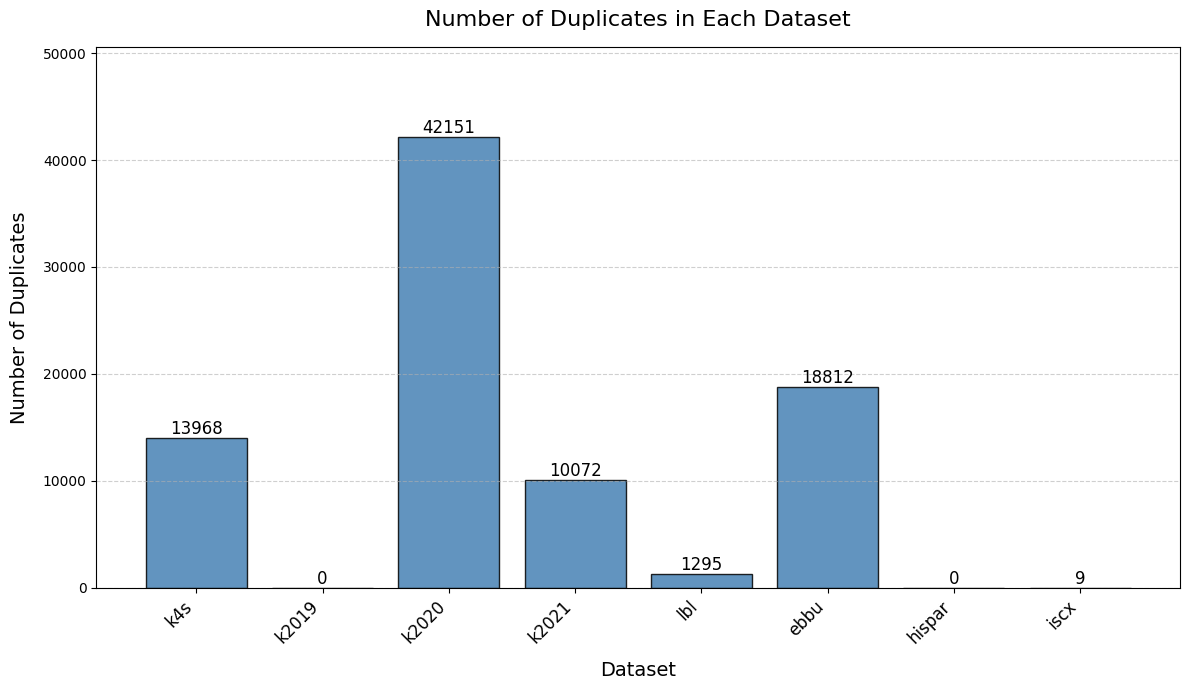

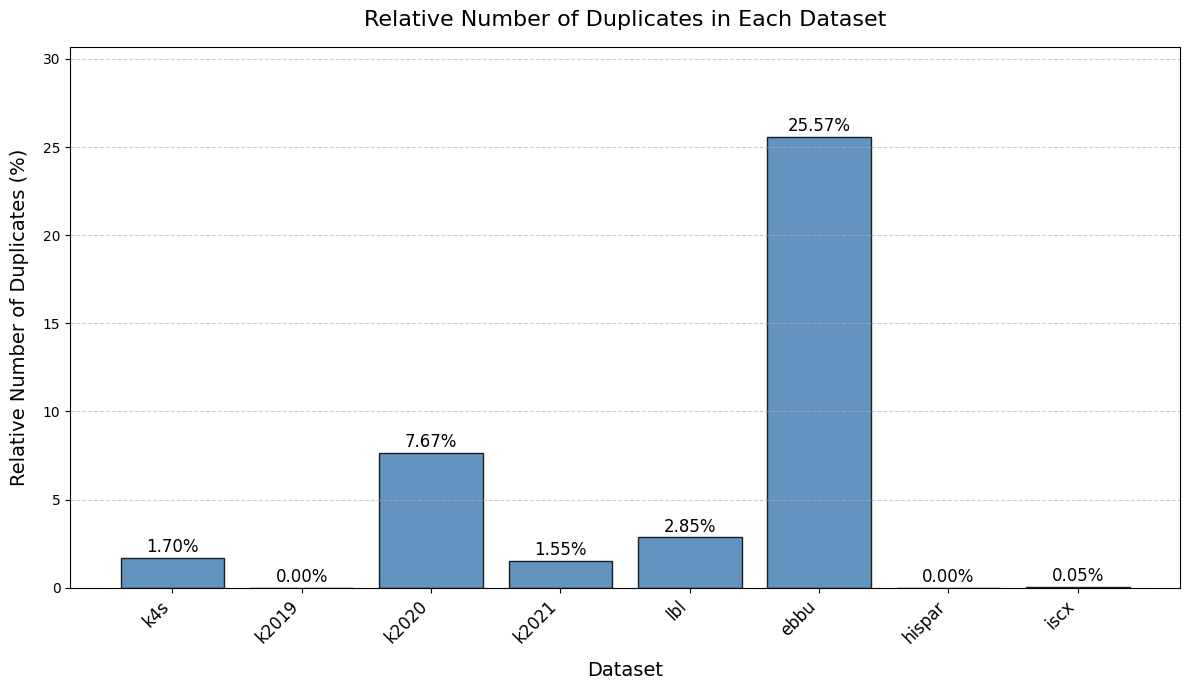

In [35]:
singleBarPlot(save = True)
print("")
singleBarPlot(relative = True, save = True)

Now we apply the function to each dataset. Keep in mind most of these datasets are used in published papers. We'd expect them to clearly be free of duplicates right?

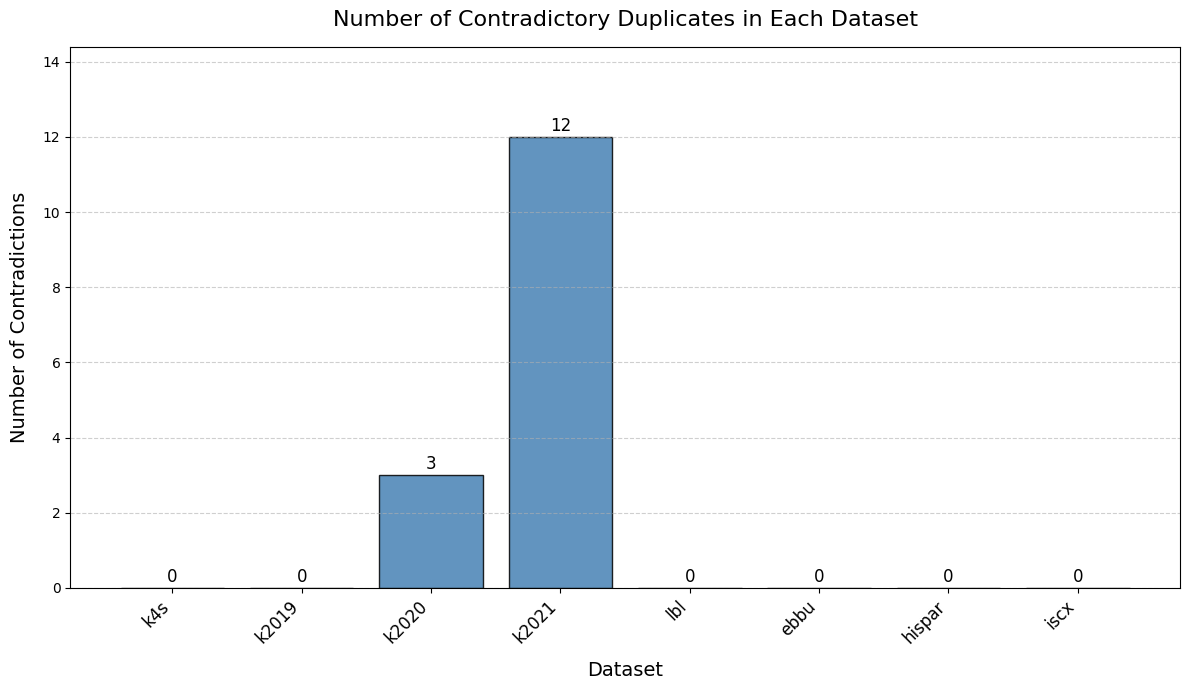


It doesn't make sense to see mislabeled duplicates with relative % (~ 0)


In [36]:
singleBarPlot(ss = True, save = True)
print("")
singleBarPlot(ss = True, relative = True)

That is, we see datasets with internal conflicting entries (same URL, with distinct labels).

## Pair-wise Full Match Analysis

In [ ]:
def create_duplicate_matrix(datasets):
    """
    Creates a pairwise duplicate matrix showing the number of duplicate URLs
    between each pair of datasets + progress bar.
    """
    dataset_names = list(datasets.keys())
    matrix = pd.DataFrame(0, index=dataset_names, columns=dataset_names)

    # Using tqdm for the outer loop (over dataset pairs)
    for i, name_i in enumerate(tqdm(dataset_names, desc="Processing Dataset Pairs (Duplicate)", unit=" Dataset")):
        df_i = datasets[name_i]
        for j, name_j in enumerate(dataset_names[i + 1:], start=i + 1):  # start from i + 1 to avoid redundant pairs
            df_j = datasets[name_j]
                
            # Concatenate df_i and df_j
            df_temp = pd.concat([df_i.drop_duplicates(subset=['url']), df_j.drop_duplicates(subset=['url'])]) # remove their own duplicates so that they dont influence later
                
            # Drop duplicates based on 'url' and count before and after
            df_temp_no_dup = df_temp.drop_duplicates(subset=['url'])
                
            # Calculate duplicates (original length - length after drop)
            duplicate_count = len(df_temp)-len(df_temp_no_dup)
                
            # Store result in the matrix
            matrix.at[name_i, name_j] = duplicate_count
            matrix.at[name_j, name_i] = duplicate_count  # Symmetric matrix

    return matrix

#######################################################################################################

def create_conflict_matrix(datasets):
    """
    Creates a pairwise conflict matrix showing the number of conflicting URLs
    between each pair of datasets + progress bar.
    """
    dataset_names = list(datasets.keys())
    matrix = pd.DataFrame(0, index=dataset_names, columns=dataset_names)

    # Using tqdm for the outer loop (over dataset pairs)
    for i, name_i in enumerate(tqdm(dataset_names, desc="Processing Dataset Pairs (Conflicts)", unit=" Dataset")):
        df_i = datasets[name_i]
        for j, name_j in enumerate(dataset_names[i + 1:], start=i + 1):  #start from i + 1 to avoid redundant pairs
            df_j = datasets[name_j]
            df_temp = pd.concat([df_i, df_j]) #remove their own duplicates so that they dont influence later

            conflict_count = resolve_duplicates(df_temp, unique=True) #unique = true in pair-wise - (because needs to be halved)
                
            #store result in the matrix
            matrix.at[name_i, name_j] = conflict_count
            matrix.at[name_j, name_i] = conflict_count #symmetric matrix

    return matrix


In [ ]:
#example:
datasets = {
    'kaggle4s': kaggle4s, 
    'kaggle2019': kaggle2019, 
    'kaggle2020': kaggle2020, 
    'kaggle2021': kaggle2021, 
    'lbl': lbl, 
    'ebbu': ebbu, 
    'hispar': hispar, 
    'iscx': iscx
}

duplicate_matrix = create_duplicate_matrix(datasets)
conflict_matrix = create_conflict_matrix(datasets)

Processing Dataset Pairs (Conflicts): 100%|██████████| 8/8 [00:27<00:00,  3.42s/ Dataset]


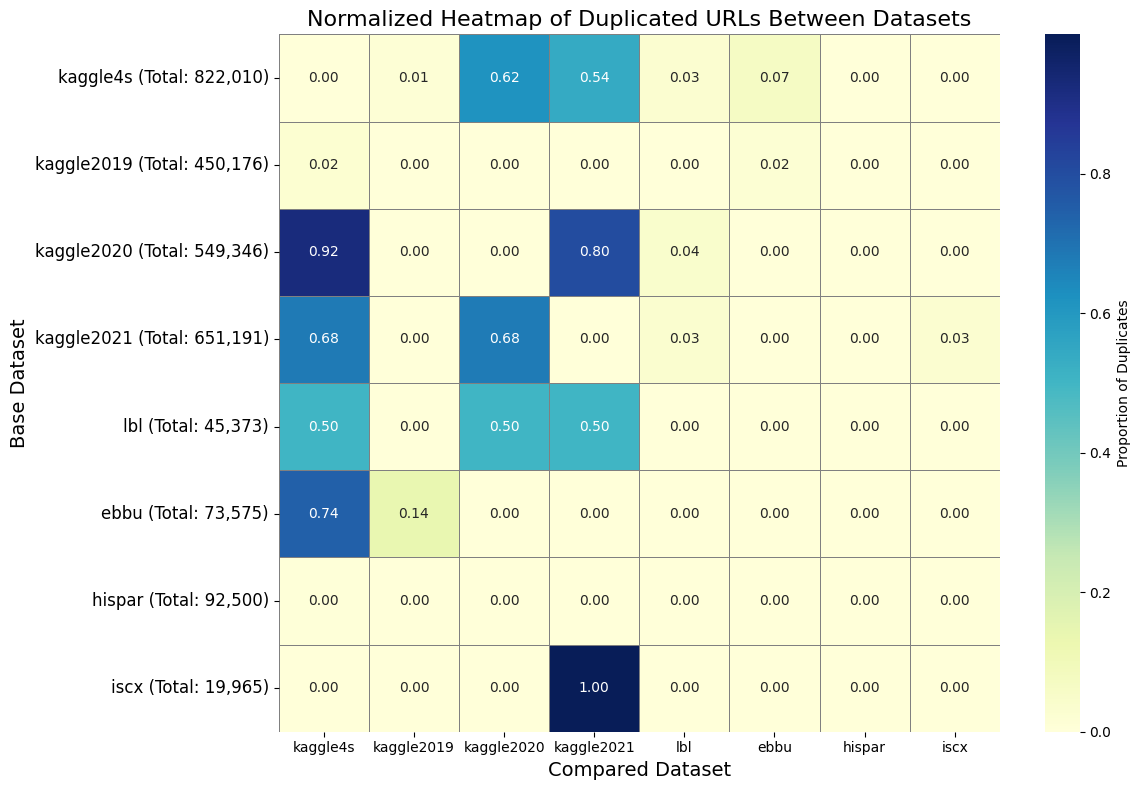

In [ ]:
np.random.seed(42)  #reproducibility

total_urls = {
}

for name in datasets.keys():
    total_urls[name] = len(datasets[name])


duplicate_df = pd.DataFrame(duplicate_matrix, index=datasets, columns=datasets) #convert to df
#empty DataFrame to store normalized values

normalized_matrix = duplicate_df.astype(float) #convert duplicate_df to float to avoid dtype incompatibility warnings

#normalize each row explicitly by dividing each value in the row by the total number of URLs for that dataset
for dataset in datasets.keys():
    normalized_matrix.loc[dataset, :] = duplicate_df.loc[dataset, :] / total_urls[dataset]

#########################################################
#create heatmap, and add total URLs as row labels
row_totals = [f"Total: {total_urls[dataset]:,}" for dataset in normalized_matrix.index]

plt.figure(figsize=(12, 8))
sns.heatmap(
    normalized_matrix, 
    cmap="YlGnBu", 
    annot=True, 
    fmt=".2f", 
    linewidths=0.5, 
    linecolor="gray",
    cbar_kws={"label": "Proportion of Duplicates"}
)

#add row total annotations on the y-axis
plt.yticks(
    ticks=np.arange(len(normalized_matrix.index)) + 0.5, 
    labels=[f"{index} ({total})" for index, total in zip(normalized_matrix.index, row_totals)], 
    rotation=0, 
    fontsize=12
)

plt.title("Normalized Heatmap of Duplicated URLs Between Datasets", fontsize=16)
plt.xlabel("Compared Dataset", fontsize=14)
plt.ylabel("Base Dataset", fontsize=14)

plt.tight_layout()
plt.savefig('C:/UNIVERSIDADE/masters/tese/Prediction/paperImgs/heatmapsDups', dpi=300, bbox_inches='tight')
plt.show()

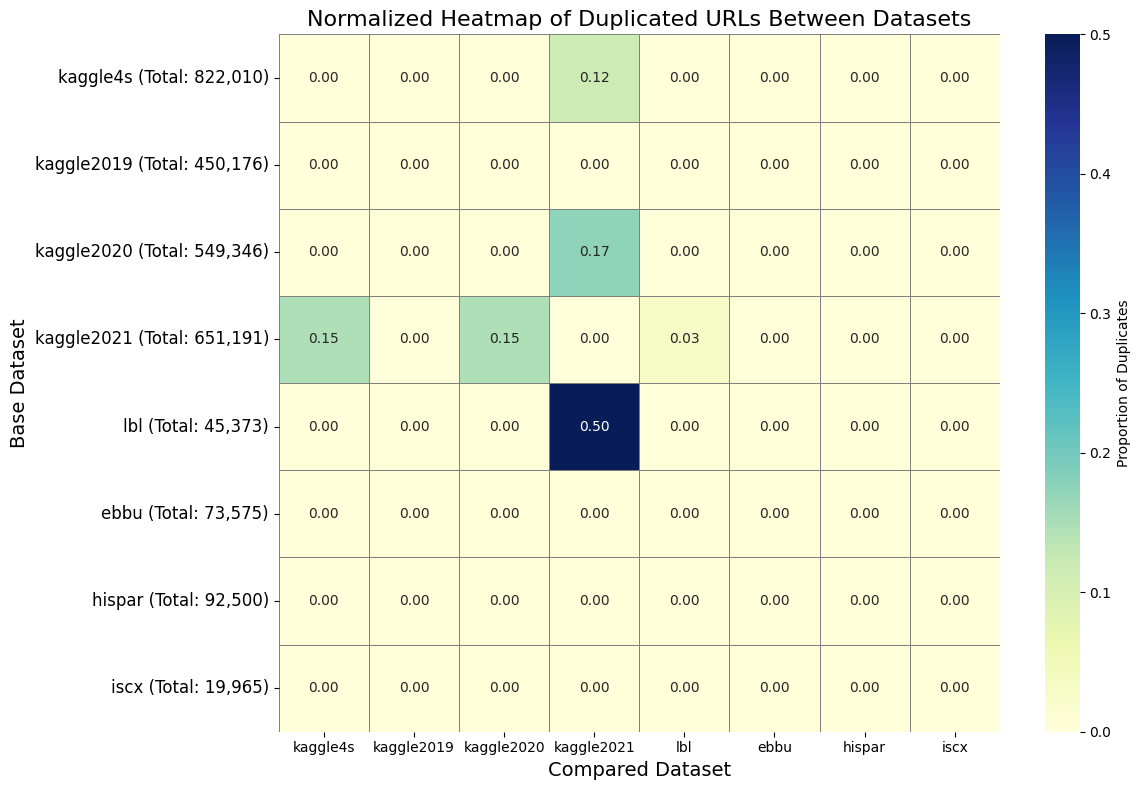

In [ ]:
np.random.seed(42) 

total_urls = {
}

for name in datasets.keys():
    total_urls[name] = len(datasets[name])

conflict_df = pd.DataFrame(conflict_matrix, index=datasets, columns=datasets)
normalized_matrix_c = conflict_df.astype(float)

for dataset in datasets.keys():
    normalized_matrix_c.loc[dataset, :] = conflict_df.loc[dataset, :] / total_urls[dataset]

#########################################################
row_totals = [f"Total: {total_urls[dataset]:,}" for dataset in normalized_matrix_c.index]

plt.figure(figsize=(12, 8))
sns.heatmap(
    normalized_matrix_c, 
    cmap="YlGnBu", 
    annot=True, 
    fmt=".2f", 
    linewidths=0.5, 
    linecolor="gray",
    cbar_kws={"label": "Proportion of Duplicates"}
)

plt.yticks(
    ticks=np.arange(len(normalized_matrix_c.index)) + 0.5, 
    labels=[f"{index} ({total})" for index, total in zip(normalized_matrix_c.index, row_totals)], 
    rotation=0, 
    fontsize=12
)

plt.title("Normalized Heatmap of Duplicated URLs Between Datasets", fontsize=16)
plt.xlabel("Compared Dataset", fontsize=14)
plt.ylabel("Base Dataset", fontsize=14)

plt.tight_layout()
plt.savefig('C:/UNIVERSIDADE/masters/tese/Prediction/paperImgs/heatmapsContradict', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
###############################
####### READABLE MATRIX #######
###############################

# print(np.round(normalized_matrix,2))
print(normalized_matrix.columns)

# # Replace "kaggle" with "k" in column names
#normalized_matrix.columns = normalized_matrix.columns.str.replace("kaggle", "k")

# # Replace "kaggle" with "k" in index names (if needed)
#normalized_matrix.index = normalized_matrix.index.str.replace("kaggle", "k")

print(np.round(normalized_matrix,6))


Index(['kaggle4s', 'kaggle2019', 'kaggle2020', 'kaggle2021', 'lbl', 'ebbu',
       'hispar', 'iscx'],
      dtype='object')
            kaggle4s  kaggle2019  kaggle2020  kaggle2021       lbl      ebbu  \
kaggle4s    0.000000    0.013331    0.617008    0.540364  0.027754  0.066621   
kaggle2019  0.024342    0.000000    0.000082    0.002386  0.000000  0.022718   
kaggle2020  0.923256    0.000067    0.000000    0.802403  0.041362  0.000013   
kaggle2021  0.682112    0.001649    0.676909    0.000000  0.034844  0.000140   
lbl         0.502810    0.000000    0.500782    0.500077  0.000000  0.000000   
ebbu        0.744315    0.139001    0.000095    0.001237  0.000000  0.000000   
hispar      0.004497    0.000605    0.000000    0.000076  0.000000  0.000162   
iscx        0.001002    0.002855    0.000000    0.999449  0.000000  0.000701   

              hispar      iscx  
kaggle4s    0.000506  0.000024  
kaggle2019  0.000124  0.000127  
kaggle2020  0.000000  0.000000  
kaggle2021  0.000011  0

____

In [1]:
from helperDS import preprocess_df

In [33]:
# Example usage:
datasets = {
    'K4S': preprocess_df(kaggle4s), 
    'K2019': preprocess_df(kaggle2019), 
    #'K2020': preprocess_df(kaggle2020), 
    'K2021': preprocess_df(kaggle2021), 
    'LBL': preprocess_df(lbl), 
    'Ebbu': preprocess_df(ebbu), 
    #'Hispar': preprocess_df(hispar), 
    'ISCX': preprocess_df(iscx)
}

duplicate_matrix = create_duplicate_matrix(datasets)
#print(duplicate_matrix)
conflict_matrix = create_conflict_matrix(datasets)


Processing Dataset Pairs (Conflicts): 100%|██████████| 6/6 [00:15<00:00,  2.53s/ Dataset]


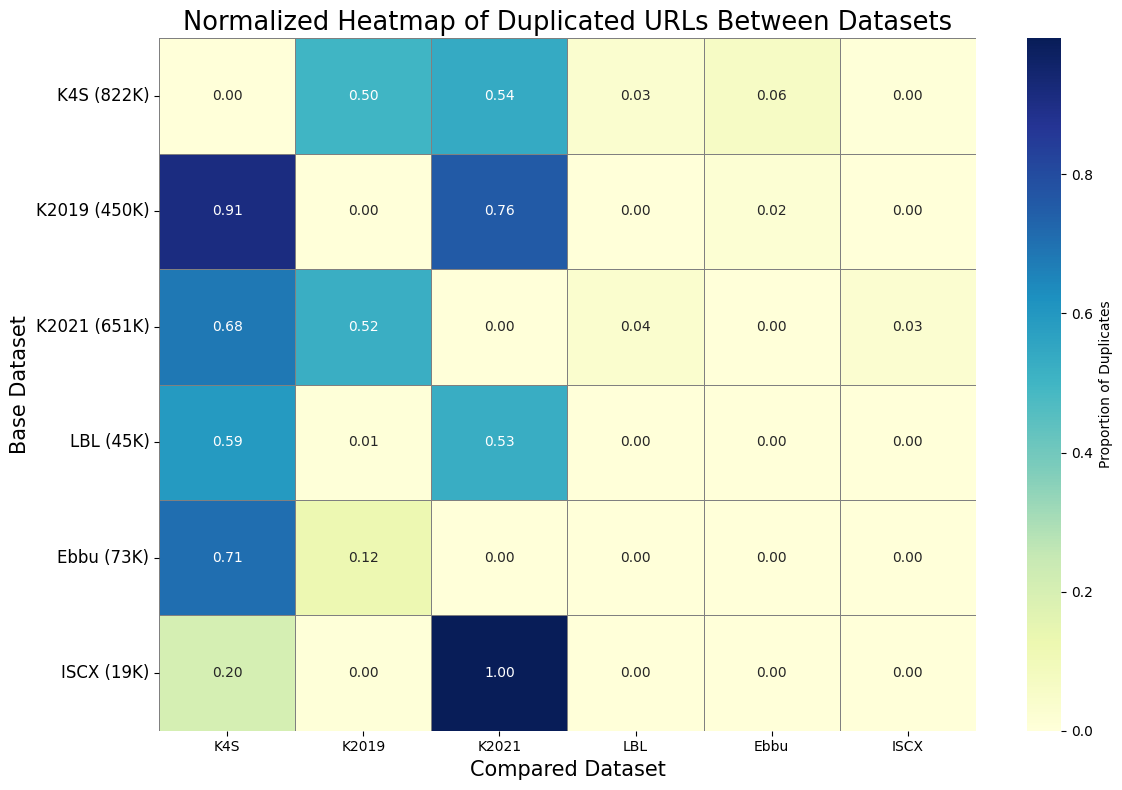

In [39]:
np.random.seed(42)  #reproducibility

total_urls = {
}

for name in datasets.keys():
    total_urls[name] = len(datasets[name])


duplicate_df = pd.DataFrame(duplicate_matrix, index=datasets, columns=datasets) #convert to df
#empty DataFrame to store normalized values

normalized_matrix = duplicate_df.astype(float) #convert duplicate_df to float to avoid dtype incompatibility warnings

#normalize each row explicitly by dividing each value in the row by the total number of URLs for that dataset
for dataset in datasets.keys():
    normalized_matrix.loc[dataset, :] = duplicate_df.loc[dataset, :] / total_urls[dataset]

#########################################################
#create heatmap, and add total URLs as row labels
row_totals = [f"{total_urls[dataset]//1000:,}" for dataset in normalized_matrix.index]

plt.figure(figsize=(12, 8))
sns.heatmap(
    normalized_matrix, 
    cmap="YlGnBu", 
    annot=True, 
    fmt=".2f", 
    linewidths=0.5, 
    linecolor="gray",
    cbar_kws={"label": "Proportion of Duplicates"}
)

#add row total annotations on the y-axis
plt.yticks(
    ticks=np.arange(len(normalized_matrix.index)) + 0.5, 
    labels=[f"{index} ({total}K)" for index, total in zip(normalized_matrix.index, row_totals)], 
    rotation=0, 
    fontsize=12
)

plt.title("Normalized Heatmap of Duplicated URLs Between Datasets", fontsize=18.5)
plt.xlabel("Compared Dataset", fontsize=15)
plt.ylabel("Base Dataset", fontsize=15)

plt.tight_layout()
plt.savefig('C:/UNIVERSIDADE/masters/tese/Prediction/paperImgs/heatmaps-prep-Dups', dpi=300, bbox_inches='tight')
plt.show()

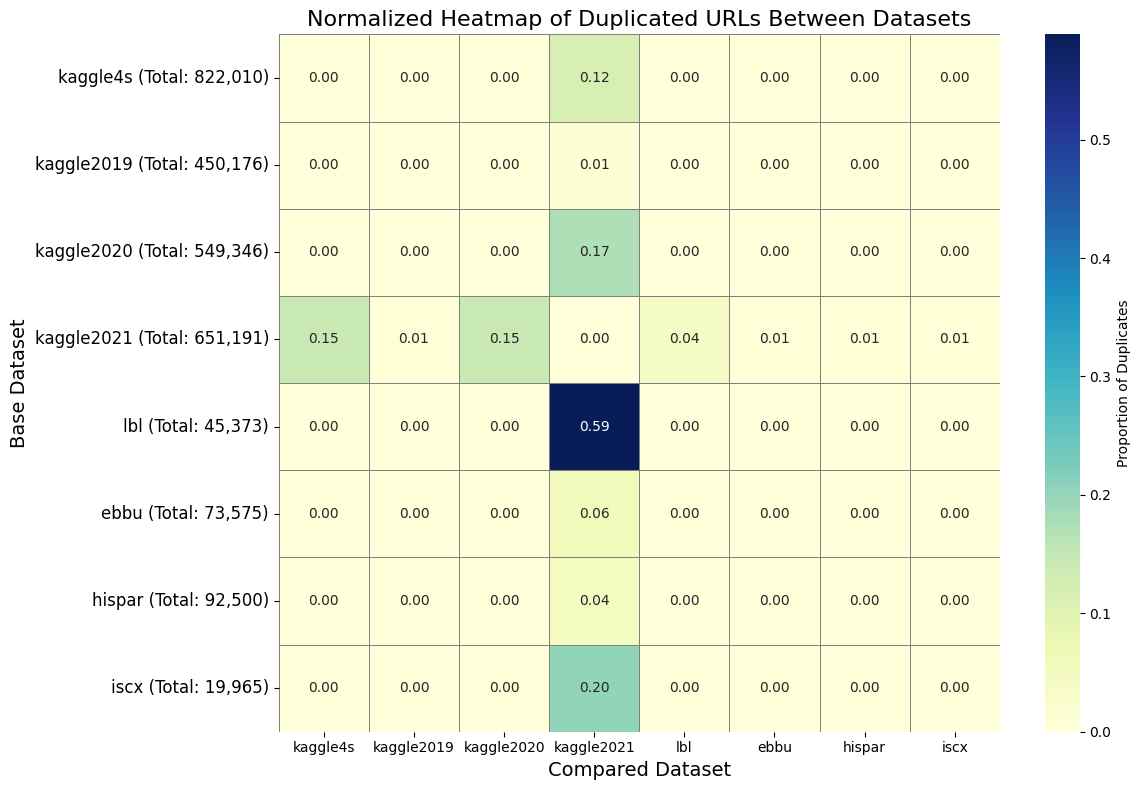

In [46]:
np.random.seed(42) 

total_urls = {
}

for name in datasets.keys():
    total_urls[name] = len(datasets[name])

conflict_df = pd.DataFrame(conflict_matrix, index=datasets, columns=datasets)
normalized_matrix_c = conflict_df.astype(float)

for dataset in datasets.keys():
    normalized_matrix_c.loc[dataset, :] = conflict_df.loc[dataset, :] / total_urls[dataset]

#########################################################
row_totals = [f"Total: {total_urls[dataset]:,}" for dataset in normalized_matrix_c.index]

plt.figure(figsize=(12, 8))
sns.heatmap(
    normalized_matrix_c, 
    cmap="YlGnBu", 
    annot=True, 
    fmt=".2f", 
    linewidths=0.5, 
    linecolor="gray",
    cbar_kws={"label": "Proportion of Duplicates"}
)

plt.yticks(
    ticks=np.arange(len(normalized_matrix_c.index)) + 0.5, 
    labels=[f"{index} ({total})" for index, total in zip(normalized_matrix_c.index, row_totals)], 
    rotation=0, 
    fontsize=12
)

plt.title("Normalized Heatmap of Duplicated URLs Between Datasets", fontsize=16)
plt.xlabel("Compared Dataset", fontsize=14)
plt.ylabel("Base Dataset", fontsize=14)

plt.tight_layout()
plt.savefig('C:/UNIVERSIDADE/masters/tese/Prediction/paperImgs/heatmaps-prep-Conf', dpi=300, bbox_inches='tight')
plt.show()

## **Discarder Tests**

This function not only addresses the duplicate problems BUT discards the URLs with conflicting labels.

In [16]:
def discarder(df, verbose = False):
    df_no_conflicts = resolve_duplicates(df, verbose=verbose)
    df_discarded_bad = df_no_conflicts.drop_duplicates(subset=['url'])
    if verbose == True:
        print(f"There were {len(df_no_conflicts)-len(df_discarded_bad)} duplicates removed.")

    return df_discarded_bad

In [93]:
df_dummy_nd5 = discarder(df_dummy)

print(df_dummy_nd5)

                    url  status
6   http://phishing.com       1
9     http://benign.com       0
11    http://random.com       0


## Full Mix Duplicate+Contradiction

At last, we do a small experiment to assess the source distribution of URLs when we combine datasets {X,Y,Z}, after removal of duplicate and conflicting URLs. Below is an important note considering datasest ordering and priority.

In [ ]:
def n_combiner(subset = None, dup = True, conflict = True, discard = True, plots = False, verbose = False):
    '''this function allows us to choose the datasets we want to merge 
            - we see plot1: the nr. of duplicates, nr. of conflicting urls, and discarded URLs; 
            - we see plot2, in the filtered dataset, the % of URLs still present for each source
    notes: 
        - a URL is discarded if he is a duplicate (only original is kept) or if he conflicts with another URL (no majority voting for label not worth the risk)
        - subset is an array containing a subset of ['kaggle4s', 'kaggle2020', 'kaggle2019', 'kaggle2021', 'lbl', 'ebbu', 'hispar', 'iscx'] '''
    

    datasets = {
        'kaggle4s': kaggle4s,
        'kaggle2019': kaggle2019,
        'kaggle2020': kaggle2020,
        'kaggle2021': kaggle2021,
        'hispar': hispar,
        'lbl': lbl,
        'ebbu': ebbu,
        'iscx': iscx,
    }

    if subset == None: 
        #assume 9 fold
        subset = ['kaggle4s', 'kaggle2020', 'kaggle2019', 'kaggle2021', 'lbl', 'ebbu', 'hispar', 'iscx']

    if subset != None:
        datasets_new = {}
        for name in subset:
            datasets_new[name] = datasets[name]
        datasets = datasets_new

    subset_str = f"Subset = {subset}"
    print(subset_str)

    ################################ concat ################################
    
    arr_df = []
    for ds_name in datasets:
        arr_df.append(datasets[ds_name])
    
    combined_df = pd.concat(arr_df, axis=0, ignore_index=True) ###very important the orde of arr_df, the first url in considered king, others dupped drop

    if verbose:
        sep_length = len(subset_str) + 3  # +3 -> slightly cleaner
        sep = '-' * sep_length
        print(sep)
        print(f"N = {len(combined_df)}")

    ################################ 1st plot ######################################

    categories = [] # ['Duplicates', 'Conflicts', 'Discarded']
    values = [] # [nr_dups, nr_conf, nr_discard]
    colors= [] #['skyblue', 'orange', 'lightgreen']
    if dup == True:
        df_no_dup = combined_df.drop_duplicates(subset=['url']) #keeps 1 from each url seen (maybe some have conflicts, but thats different)
        nr_dups = len(combined_df)-len(df_no_dup)
        if verbose: print(f"Found {nr_dups} duplicates.")

        categories.append('Duplicates')
        values.append(nr_dups)
        colors.append('skyblue')

    if conflict == True:
        df_no_conflicts = resolve_duplicates(combined_df)
        nr_conf = len(combined_df)-len(df_no_conflicts)
        if verbose: print(f"Found {nr_conf} conflicts.")

        categories.append('Conflicts')
        values.append(nr_conf)
        colors.append('orange')

    if discard==True:
        df_discard = discarder(combined_df)
        nr_discard = len(combined_df)-len(df_discard)
        if verbose: print(f"=> Found {nr_discard} URLs to discard.")

        categories.append('Discarded')
        values.append(nr_discard)
        colors.append('red')
        combined_df = df_discard #for true source_values
    
    #generate title
    if len(categories) == 1:
        title = categories[0]
    elif len(categories) == 2:
        title = f"{categories[0]} and {categories[1]}"
    else:
        title = ", ".join(categories[:-1]) + f", and {categories[-1]}"

    ############## 2nd plot ##############
    source_map = {
        0: 'kaggle4s',
        1: 'kaggle2020',
        2: 'kaggle2019',
        3: 'kaggle2021',
        4: 'lbl',
        5: 'ebbu',
        6: 'hispar',
        7: 'iscx'
    }

    source_counts = combined_df['source'].value_counts().sort_index()
    sources = source_counts.index.map(source_map)  # Map the numeric values to their string labels
    source_values = source_counts.values

    ######################################

    if plots == True:

        plt.figure(figsize=(16, 6)) 
        #first plot
        plt.subplot(1, 2, 1)  #figure size
        plt.bar(categories, values, color=colors, edgecolor = 'black')

        #labels and title
        plt.xlabel('Categories')
        plt.ylabel('Count')
        plt.title(f'Histogram of {title}')
        plt.xticks(rotation=0)  #keep category labels horizontal

        #value annotations on top of bars
        for i, value in enumerate(values):
            plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

        #second plot
        plt.subplot(1, 2, 2)  #1 row, 2 columns, 2nd plot
        plt.bar(sources, source_values, color='skyblue', edgecolor = 'black')
        plt.xlabel('Source')
        plt.ylabel('Count')
        plt.title('Source Histogram')
        plt.xticks(range(len(sources)), sources, rotation=0, ha='right') #rotate for better visibility

        #calculate the maximum value for normalization below
        max_val = max(source_values)

        for i, val in enumerate(source_values):
            L = len(datasets[sources[i]]) #length of dataset for the current source
            ratio = 100 * (val/L) #calculate the ratio as a percentage
            
            #determine vertical position for the ratio based on thresholds
            ratio_str = f"{np.around(ratio, 1)} %"
            if val > 0.2 * max_val:
                ratio_position = val / 2.15
            elif val > 0.08 * max_val:
                ratio_position = val / 2.8
            else:
                ratio_position = val+35000  #avoid overlapping or bad formatting for very small values
                ratio_str = "(" + ratio_str + ")"
            
            plt.text(i, val, str(val), ha='center', va='bottom', fontsize=10) #value above bar
            plt.text(i, ratio_position, ratio_str, ha='center', va='bottom', fontsize=10) #add ratio

        #show the plot
        plt.tight_layout()
        plt.show()
    
    ############################
    result = [combined_df]
    if dup == True:
        result.append(nr_dups)
    if conflict == True:
        result.append(nr_conf)
    if discard == True:
        result.append(nr_discard)
        if verbose: print(f"Final dataset has N = {len(combined_df)}.")
    
    return result

Note: In the following analysis, whenever a URL has to be discarded due to being duplicate, an order has to be chosen (e.g. if an URL is in dataset A and B, once we merge, which source do we decide to keep?) Below is the chosen order:

*kaggle4s* > *kaggle2020* > *kaggle2019* > *kaggle2021* > *hispar* > *lbl* > *ebbu* > *iscx*

**Note**: Even though there's the hierarchy, high-priority datasets will still lose some because they have duplicates within themselves.

## 8 Folds

Subset = ['kaggle4s', 'kaggle2020', 'kaggle2019', 'kaggle2021', 'hispar', 'lbl', 'ebbu', 'iscx']
---------------------------------------------------------------------------------------------------
N = 2704136
Found 1147008 duplicates.
Found 310774 conflicts.
=> Found 1243014 URLs to discard.


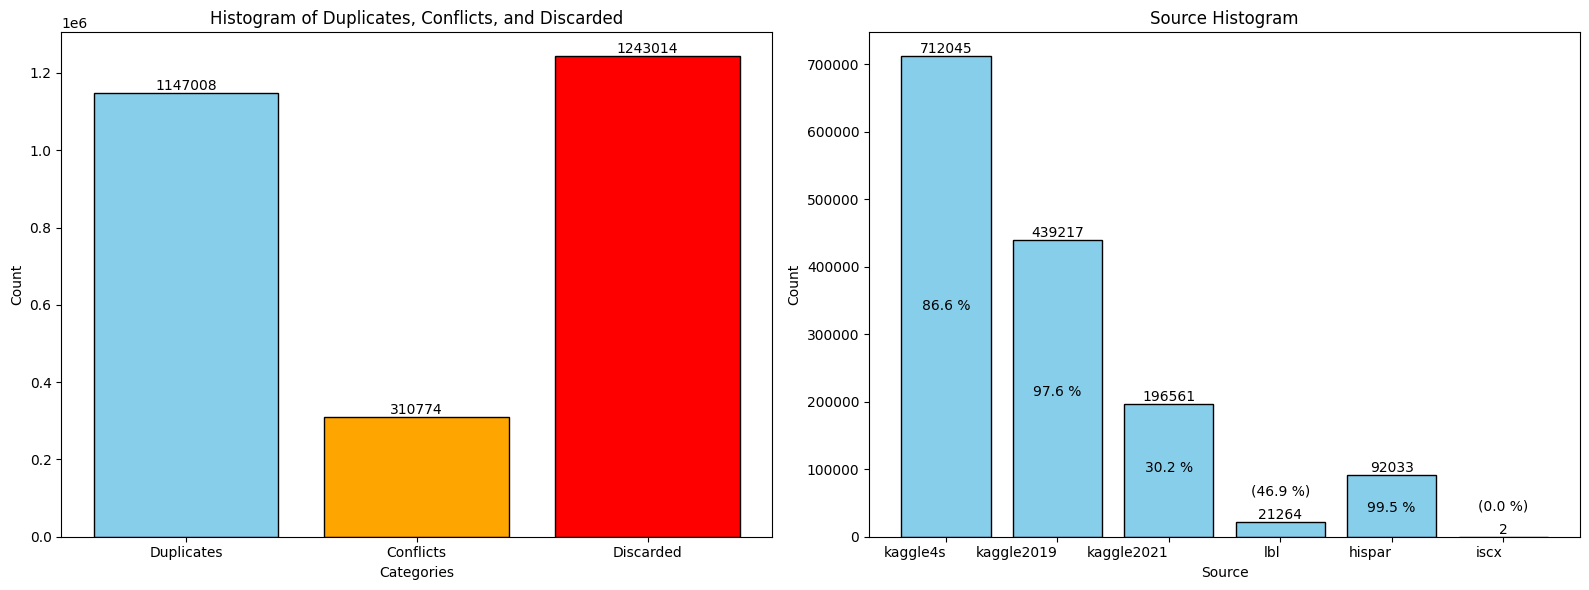

Final dataset has N = 1461122.


In [419]:
res8 = n_combiner(['kaggle4s', 'kaggle2020', 'kaggle2019', 'kaggle2021', 'hispar', 'lbl', 'ebbu', 'iscx'], plots = True, verbose = True)

It's clear from the conflict heatmap that *kaggle2021* is the main conflict-inducing dataset.

## 7 Folds

Let's try removing the culprit!

Subset = ['kaggle4s', 'kaggle2020', 'kaggle2019', 'hispar', 'lbl', 'ebbu', 'iscx']
-------------------------------------------------------------------------------------
N = 2052945
Found 672479 duplicates.
Found 8 conflicts.
=> Found 672482 URLs to discard.


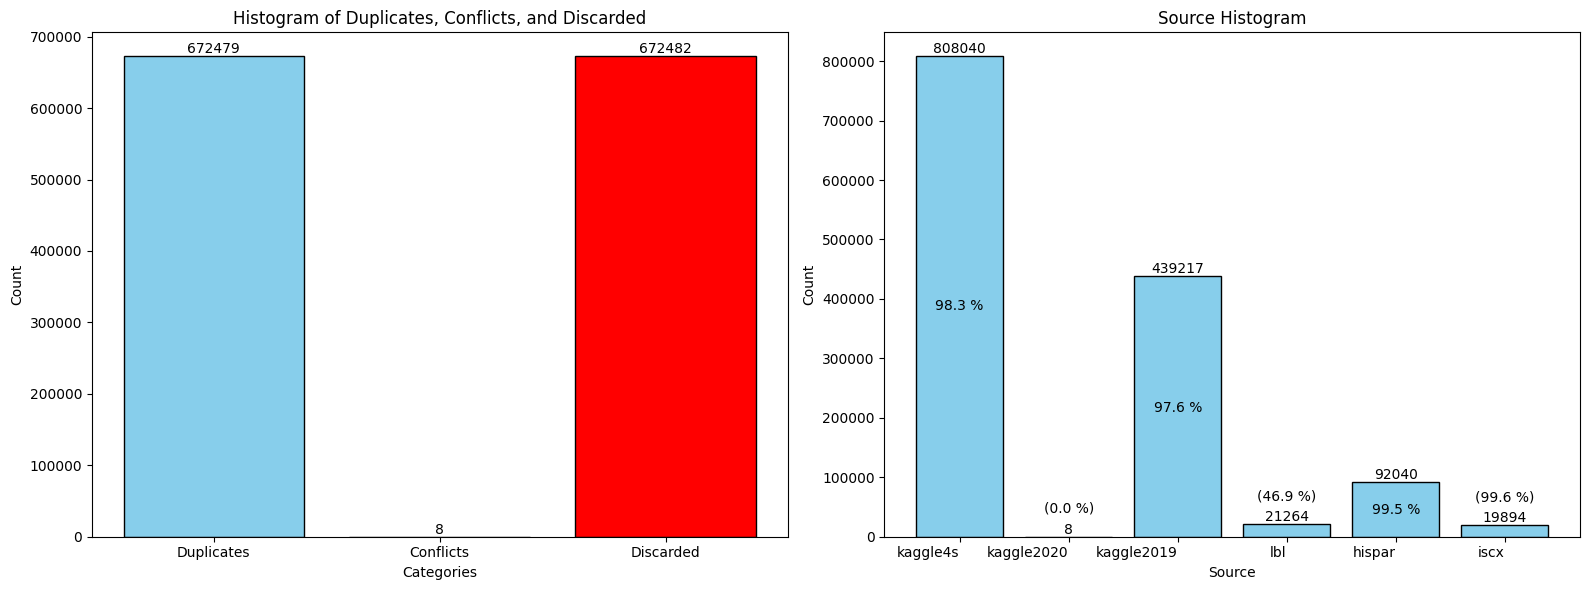

Final dataset has N = 1380463.


In [402]:
res7 = n_combiner(['kaggle4s', 'kaggle2020', 'kaggle2019', 'hispar', 'lbl', 'ebbu', 'iscx'], plots = True, verbose = True) # add , plot = True;

It's clear from the duplicate heatmap that *kaggle2020* is composed mostly of *kaggle4s*, *kaggle2021* URLs.

## 6 Folds

Let's try removing *kaggle2020*.

Subset = ['kaggle4s', 'lbl', 'kaggle2019', 'ebbu', 'hispar', 'iscx']
-----------------------------------------------------------------------
N = 1503599
Found 123141 duplicates.
Found 4 conflicts.
=> Found 123143 URLs to discard.


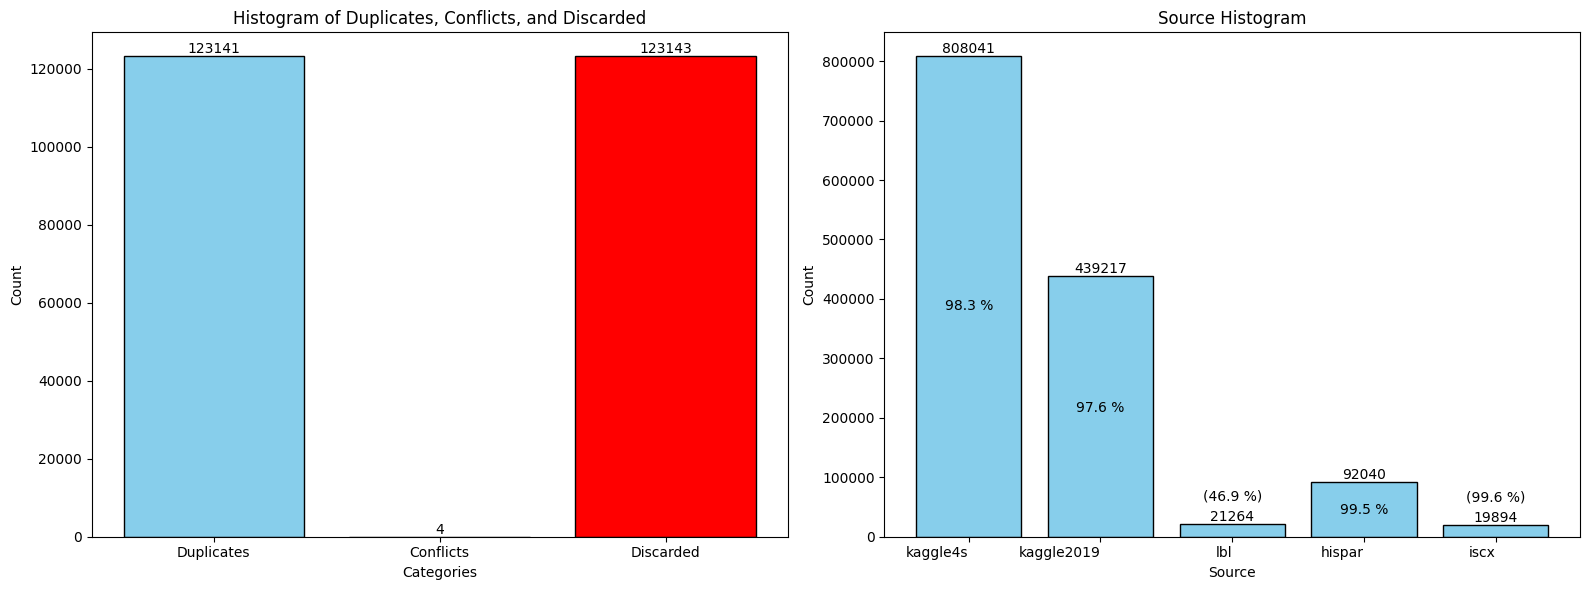

Final dataset has N = 1380456.


In [403]:
res6 = n_combiner(['kaggle4s', 'lbl', 'kaggle2019', 'ebbu', 'hispar', 'iscx'], plots = True, verbose = True)

## 5 Folds

Up next is *ebbu2017*. It's already as if we removed it because it's a subset of this (essentially made of *kaggle4s* and *kaggle2019* and duplicates of itself).

Subset = ['kaggle4s', 'kaggle2019', 'lbl', 'hispar', 'iscx']
---------------------------------------------------------------
N = 1430024
Found 49566 duplicates.
Found 4 conflicts.
=> Found 49568 URLs to discard.


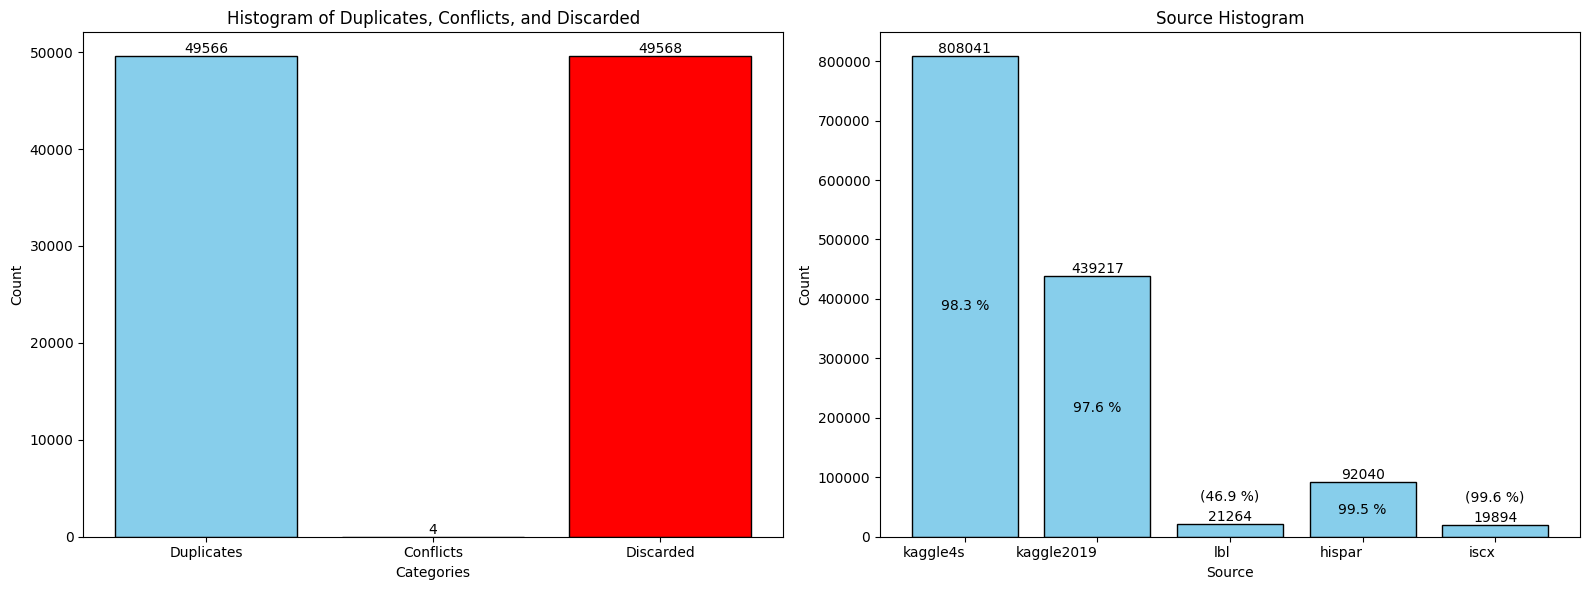

Final dataset has N = 1380456.


In [409]:
res5_1 = n_combiner(['kaggle4s', 'kaggle2019', 'lbl', 'hispar', 'iscx'], plots = True, verbose = True)

## 4 Folds

Next up we remove lbl (essentially half of it is dropped by *kaggle4s*).

Subset = ['kaggle4s', 'kaggle2019', 'hispar', 'iscx']
--------------------------------------------------------
N = 1384651
Found 25457 duplicates.
Found 4 conflicts.
=> Found 25459 URLs to discard.


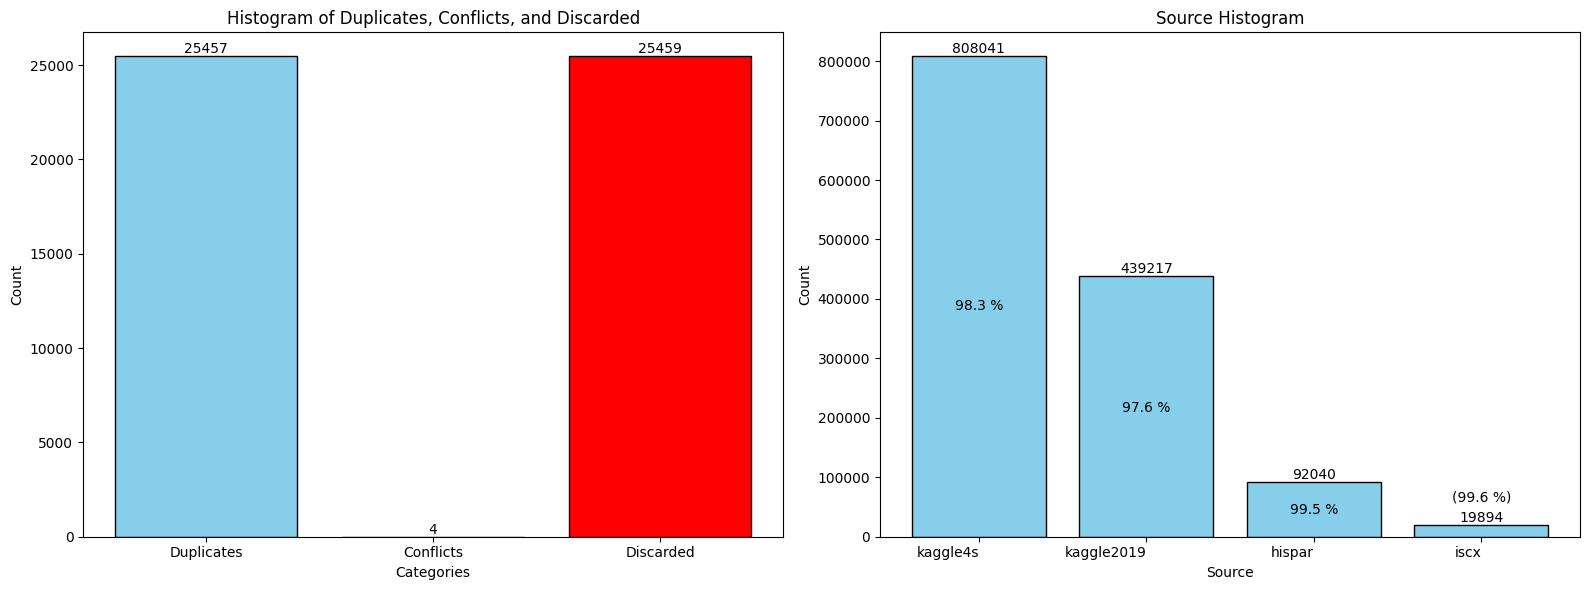

Final dataset has N = 1359192.


In [413]:
res4_0 = n_combiner(['kaggle4s', 'kaggle2019', 'hispar', 'iscx'], verbose = True, plots = True)

res4_1 = n_combiner(['lbl', 'ebbu', 'hispar', 'iscx'], verbose = True, plots = True)

## 3 Folds

Subset = ['kaggle4s', 'kaggle2019', 'iscx']
----------------------------------------------
N = 1292151
Found 24997 duplicates.
Found 2 conflicts.
=> Found 24998 URLs to discard.


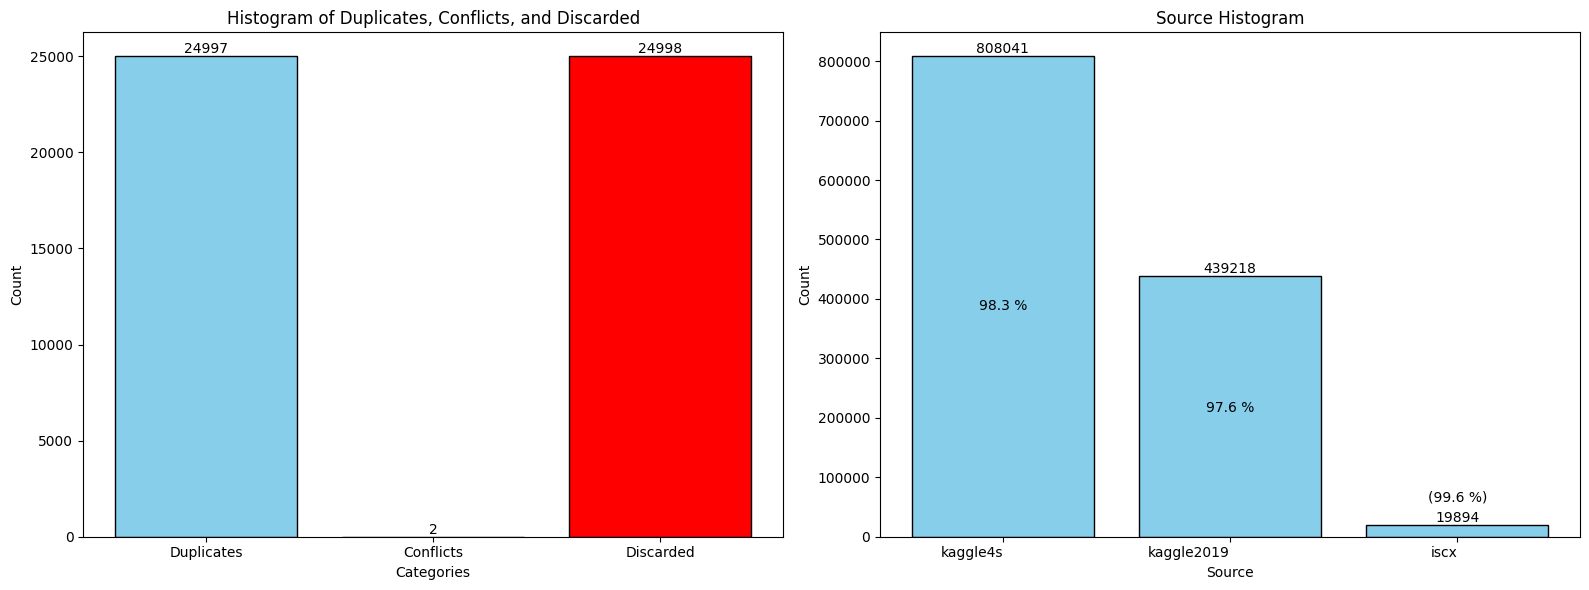

Final dataset has N = 1267153.
_______________________________________________


Subset = ['iscx', 'lbl', 'ebbu']
-----------------------------------
N = 138913
Found 20130 duplicates.
Found 0 conflicts.
=> Found 20130 URLs to discard.


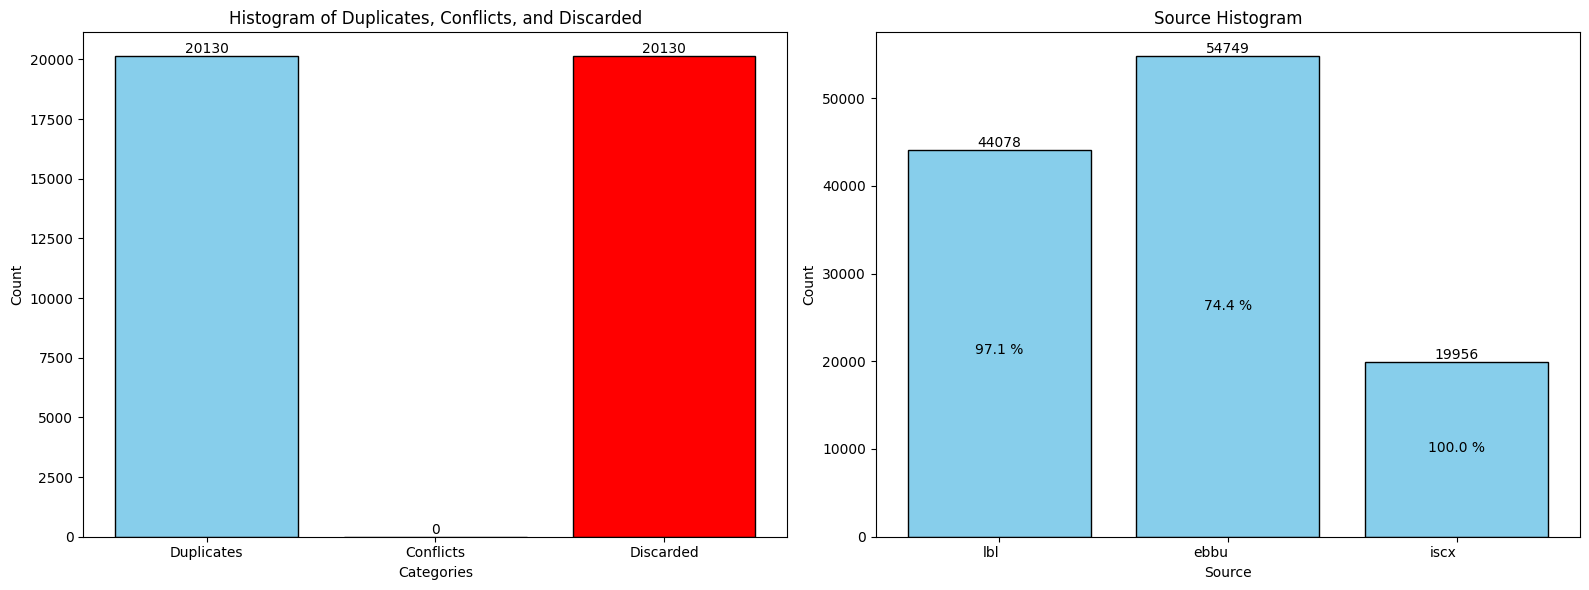

Final dataset has N = 118783.
_______________________________________________


Subset = ['hispar', 'lbl', 'ebbu']
-------------------------------------
N = 211448
Found 20122 duplicates.
Found 0 conflicts.
=> Found 20122 URLs to discard.


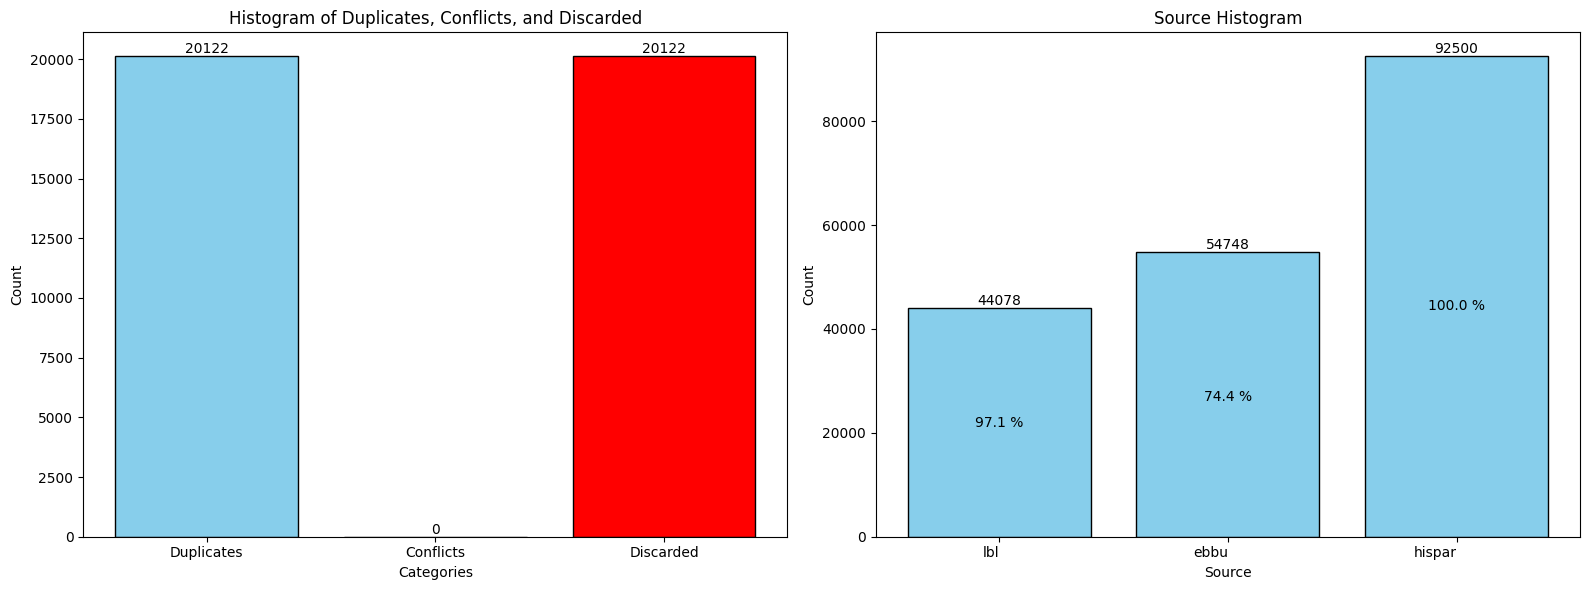

Final dataset has N = 191326.
_______________________________________________




In [18]:
res3_1 = n_combiner(['kaggle4s', 'kaggle2019', 'iscx'], verbose = True, plots = True)
print("_______________________________________________\n\n")

res3_2 = n_combiner(['iscx', 'lbl', 'ebbu'], verbose = True, plots = True)
print("_______________________________________________\n\n")

res3_3 = n_combiner(['hispar', 'lbl', 'ebbu'], verbose = True, plots = True)
print("_______________________________________________\n\n")

#res3_4 = n_combiner(['kaggle4s', 'lbl', 'ebbu'], verbose = True, plots = True)
#'kaggle4s', 'kaggle2020', 'kaggle2021'

# Feature Peek

To finish off, lets create a function to take a peek at the feature distribution of a given dataset. For illustration, we'll use the *kaggle2019* mainly to emphasize its "protocol bias problem".

In [81]:
def compare_features(df, bins_url = 100):
    kaggle2020f = df.copy()
    kaggle2020f["url_length"] = kaggle2020f["url"].str.len()
    kaggle2020f["num_digits"] = kaggle2020f["url"].str.count(r'\d')
    kaggle2020f["num_special_chars"] = kaggle2020f["url"].str.count(r'[!@#$%^&*(),?":{}|<>]')
    kaggle2020f["num_subdomains"] = kaggle2020f["url"].str.count(r'\.')
    kaggle2020f["has_https"] = kaggle2020f["url"].str.startswith('https').astype(int)
    # Feature calculations remain the same
    features = ["url_length", "num_digits", "num_special_chars", "num_subdomains", "has_https"]
    
    plt.style.use('ggplot')
    
    for feature in features:
        phish = kaggle2020f[kaggle2020f["status"] == 1][feature]
        benign = kaggle2020f[kaggle2020f["status"] == 0][feature]
        combined = pd.concat([phish, benign])

        plt.figure(figsize=(10, 6))
        
        # Feature-type specific handling
        if feature == "has_https":  # Binary feature
            for data, label, color in [(phish, 'Phishing', 'red'), (benign, 'Benign', 'blue')]:
                counts = data.value_counts(normalize=True).sort_index()
                plt.bar(counts.index + 0.1*(1 if label == 'Phishing' else -1), 
                        counts.values, 
                        width=0.2, alpha=0.7, label=label, color=color)
            plt.xticks([0, 1], ['No HTTPS', 'HTTPS'])
            xmin, xmax = -0.5, 1.5
            
        else:  # Numeric features
            # Smart range calculation (5th-95th percentile)
            xmin, xmax = np.percentile(combined, [5, 95])
            
            if feature in ["num_digits", "num_special_chars", "num_subdomains"]:
                # Integer-aligned bins for count data
                bin_width = max(1, int((xmax - xmin)/10))
                bins = np.arange(xmin, xmax + bin_width, bin_width)
            else:  # Continuous data (url_length)
                # Freedman-Diaconis rule for robust binning
                q75, q25 = np.percentile(combined, [75, 25])
                iqr = q75 - q25
                bin_width = 2 * iqr * (len(combined) ** (-1/3))
                if feature == 'url_length': bins = bins_url
                else: bins = np.arange(xmin, xmax + bin_width, bin_width*2)

            # Histogram plotting
            plt.hist(phish, bins=bins, density=True, alpha=0.5, 
                     label='Phishing', color='red')
            plt.hist(benign, bins=bins, density=True, alpha=0.5, 
                     label='Benign', color='blue')
            
            # Mean markers
            plt.axvline(phish.mean(), color='darkred', linestyle='--', 
                        label=f'Phishing Mean ({phish.mean():.2f})')
            plt.axvline(benign.mean(), color='darkblue', linestyle='--', 
                        label=f'Benign Mean ({benign.mean():.2f})')

        # Common formatting
        plt.xlim(xmin, xmax)
        plt.xlabel(feature.replace('_', ' ').title())
        plt.ylabel('Density' if feature != 'has_https' else 'Proportion')
        plt.title(f"Distribution of {feature.replace('_', ' ').title()}")
        plt.legend()
        plt.tight_layout()
        plt.show()

------------------------------------------------ kaggle2019 ------------------------------------------------


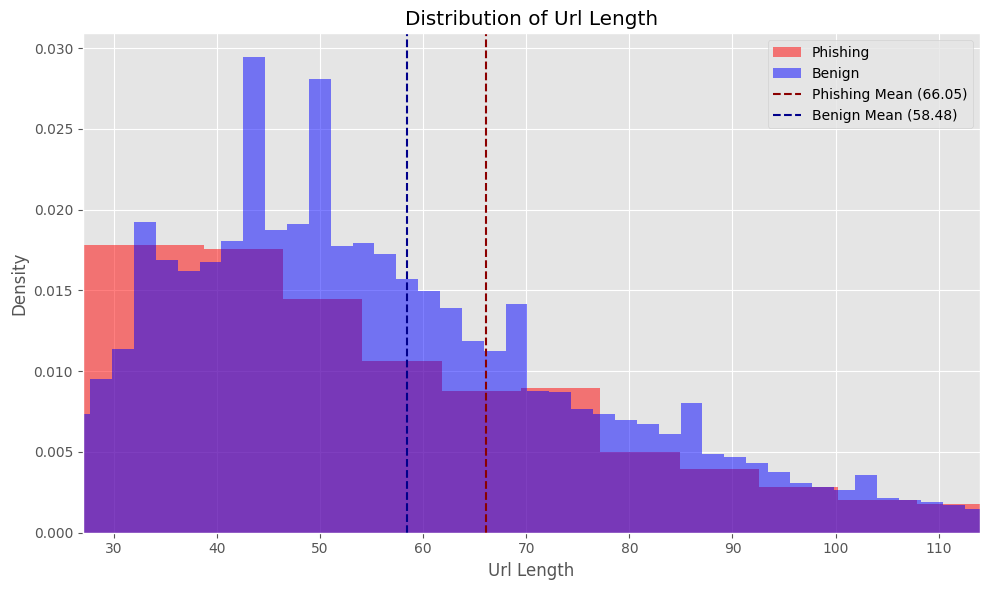

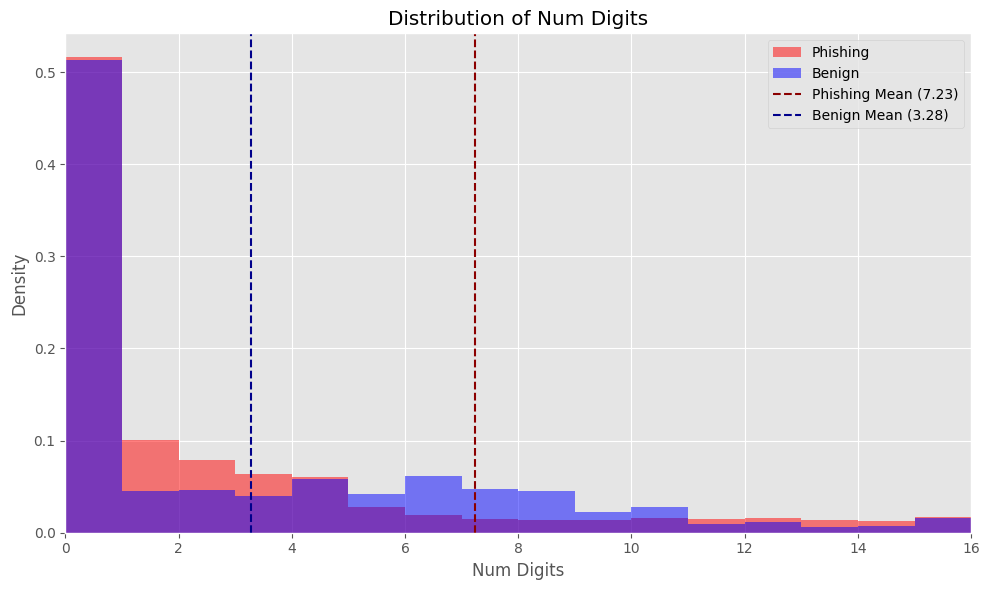

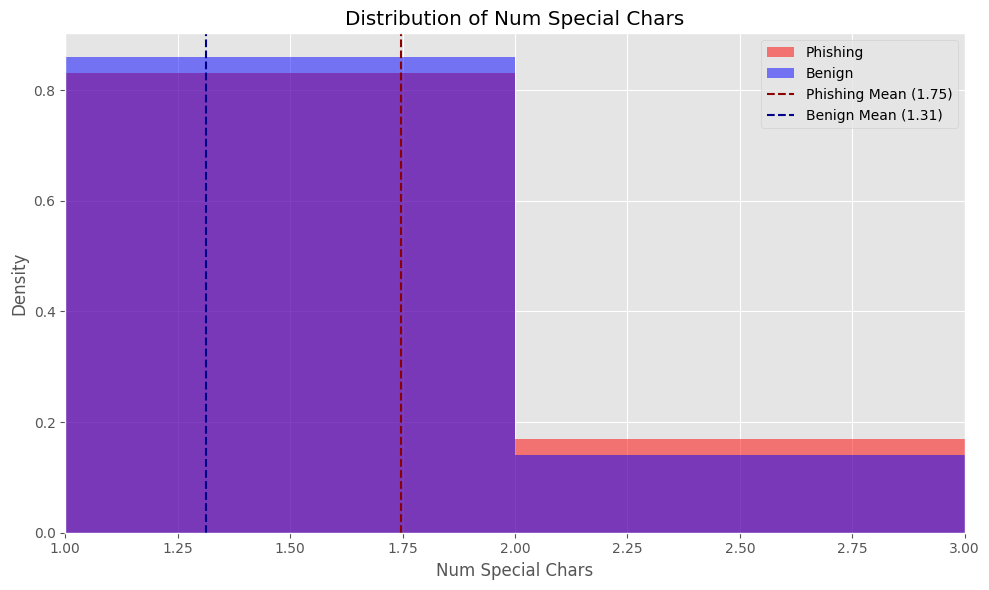

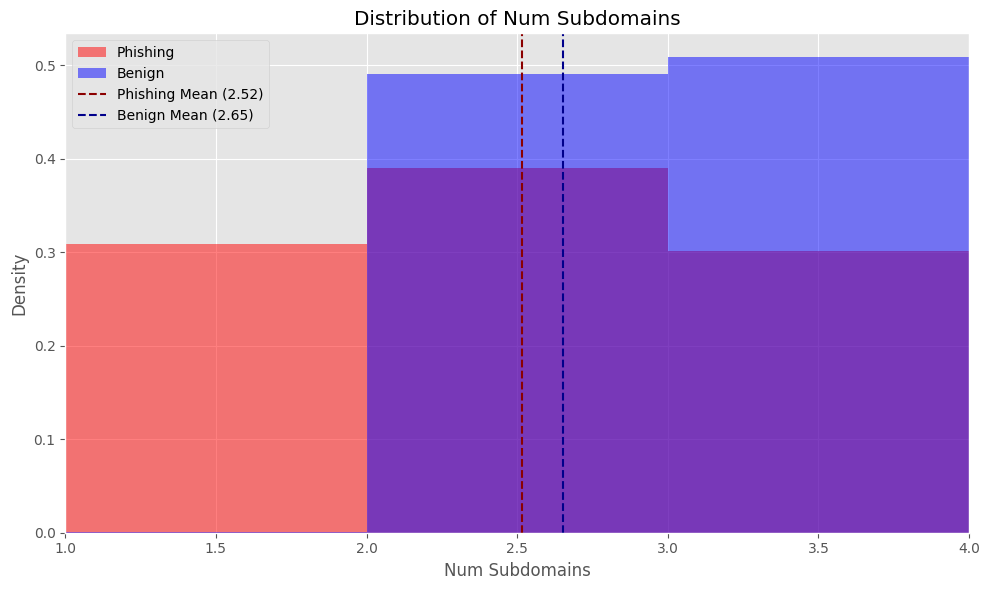

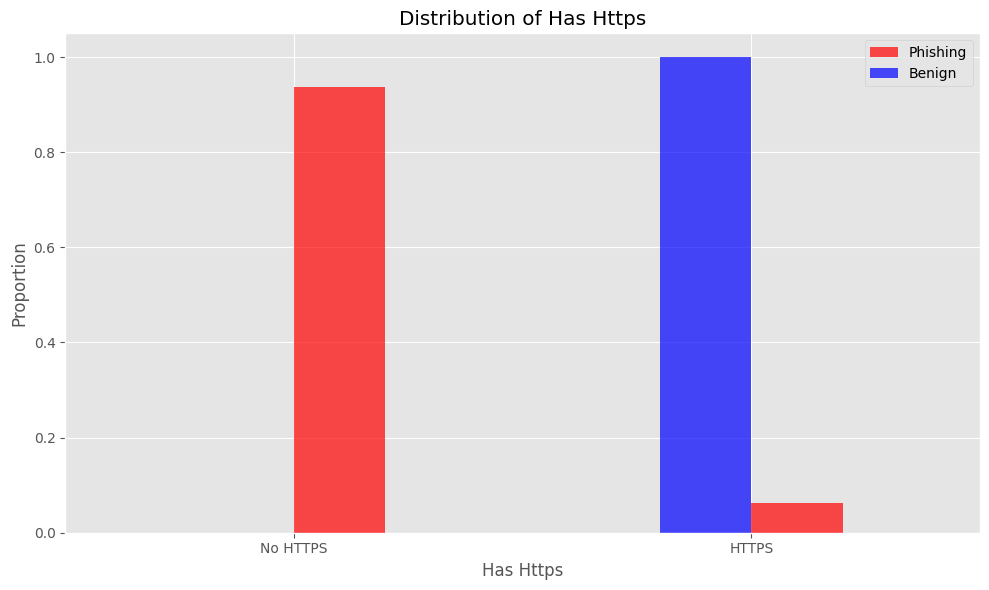

In [91]:
print("------------------------------------------------ kaggle2019 ------------------------------------------------")
compare_features(kaggle2019, bins_url = 300)

In [ ]:
def count_url_prefixes(df):
    #priority order to avoid overlapping counts
    prefixes = ['https://', 'http://']
    
    result = {prefix: {"phish": 0, "benign": 0} for prefix in prefixes}
    
    for prefix in prefixes:
        # Count occurrences for phishing and benign classes
        result[prefix]["phish"] = df[(df["status"] == 1) & (df["url"].str.startswith(prefix))].shape[0]
        result[prefix]["benign"] = df[(df["status"] == 0) & (df["url"].str.startswith(prefix))].shape[0]
    
    # Display results neatly
    for prefix, counts in result.items():
        print(f"Prefix '{prefix}': Phishing = {counts['phish']}, Benign = {counts['benign']}")

    return result

#usage
results2019 = count_url_prefixes(kaggle2019)
print("")
results_hp = count_url_prefixes(hispar)
print("")
results_ebbu = count_url_prefixes(hispar)
print("")
results_iscx = count_url_prefixes(iscx)
print("")
results2020 = count_url_prefixes(kaggle2020)

Prefix 'https://': Phishing = 6483, Benign = 345702
Prefix 'http://': Phishing = 97948, Benign = 0

Prefix 'https://': Phishing = 11822, Benign = 40015
Prefix 'http://': Phishing = 34428, Benign = 6218

Prefix 'https://': Phishing = 11822, Benign = 40015
Prefix 'http://': Phishing = 34428, Benign = 6218

Prefix 'https://': Phishing = 172, Benign = 546
Prefix 'http://': Phishing = 9791, Benign = 9454

Prefix 'https://': Phishing = 7, Benign = 0
Prefix 'http://': Phishing = 100, Benign = 0


In [59]:
def visualize_prefix_counts(result):
    prefixes = list(result.keys())
    
    # Data for plotting
    phishing_counts = [result[prefix]['phish'] for prefix in prefixes]
    benign_counts = [result[prefix]['benign'] for prefix in prefixes]
    
    x = range(len(prefixes))  # X-axis positions

    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Bar plot for phishing and benign counts
    plt.bar([p - 0.2 for p in x], phishing_counts, width=0.4, color='red', label='Phishing', edgecolor = 'black')
    plt.bar([p + 0.2 for p in x], benign_counts, width=0.4, color='green', label='Benign', edgecolor = 'black')
    
    plt.xticks(x, prefixes)
    plt.ylabel('Count')
    plt.xlabel('URL Prefix')
    plt.title('Distribution of Phishing and Benign URLs by Prefix')
    plt.legend()
    
    # Show exact counts above bars
    for i, v in enumerate(phishing_counts):
        plt.text(i - 0.3, v + max(phishing_counts) * 0.02, str(v), color='black', ha='center')
    
    for i, v in enumerate(benign_counts):
        plt.text(i + 0.2, v + max(phishing_counts) * 0.02, str(v), color='black', ha='center')

    plt.show()

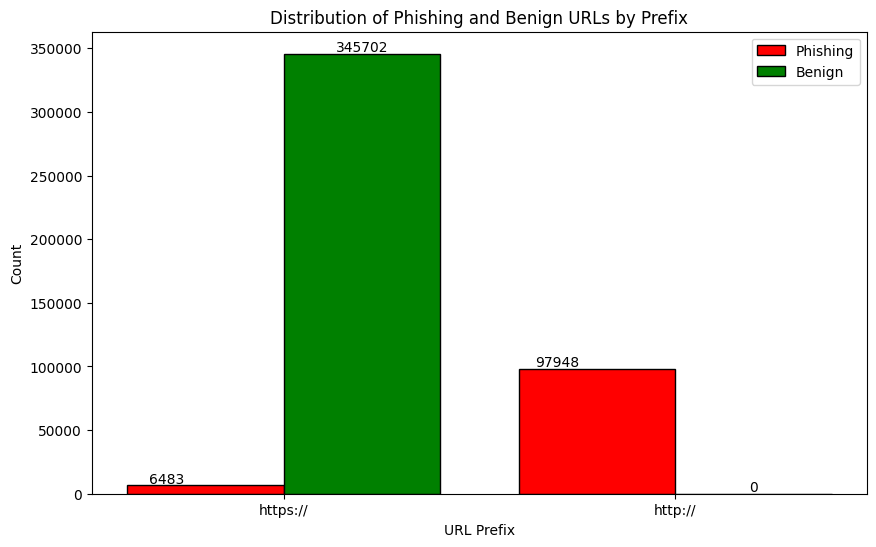

In [60]:
visualize_prefix_counts(results2019)

## Inconsistency in prefixes

At last, there are some minor problems to explore in preprocessing. Look at the example below (the prefix removal wouldnt catch it).

In [ ]:
for i in range(len(kaggle4s)): 
    if i>=11685 and i<=15000:
        continue
    url_i = kaggle4s['url'].iloc[i]
    if url_i[0:3]=='www' or url_i[0:4]=='http': #last includes https
        print(f"url_i = {url_i}, i = {i}")
        break

url_i = www1-account-billing-amaz0n.confirm-acc.com, i = 27986


# References

**[1]** "Phishing and Legitimate URLs" - https://www.kaggle.com/datasets/harisudhan411/phishing-and-legitimate-urls/data

**[2]** "Kaggle4S" - https://huggingface.co/datasets/ealvaradob/phishing-dataset

**[3]** "Phishing Site URLs" - https://www.kaggle.com/datasets/taruntiwarihp/phishing-site-urls 

[4] "Malicious URL detection using NLP, machine learning and FLASK" by A. Lakshmanarao, et al. ####embedd paper link

**[5]**  "Malicious And Benign URLs" - https://www.kaggle.com/siddharthkumar25/malicious-and-benign-urls

[6] "Towards lightweight URL-based phishing detection" by A. Butnaru, et al. ####embedd paper link

[7] Shantanu, B. Janet, and R. J. A. Kumar, ‘‘Malicious URL detection:
A comparative study,’’ 

[8] S. Afzal, M. Asim, A. R. Javed, M. O. Beg, and T. Baker, ‘‘URLdeepDetect: A deep learning approach for detecting malicious URLs using
semantic vector models,’’

**[9]** "Malicious URLs dataset" - https://www.kaggle.com/sid321axn/malicious-urls-dataset

[10] V. Vundavalli, F. Barsha, M. Masum, H. Shahriar, and H. Haddad, ‘‘Malicious URL detection using supervised machine learning techniques,’’

**[11]** Look Before You Leap: Detecting Phishing Web Pages by Exploiting Raw URL And HTML Characteristics by Chidimma Opara, et al.

**[12]** "Look Before you Leap Dataset" - https://www.kaggle.com/datasets/guchiopara/look-before-you-leap

[13] A Survey of Intelligent Detection Designs of HTML URL Phishing Attacks by

[14] Machine learning based phishing detection from URLs, Sahingoz et al.

**[15]** "EBBU2017 Dataset" - https://github.com/ebubekirbbr/pdd/tree/master/input

[16] Fariza, et al. Generalization UDA

[17] Fariza, et al. 1-Shot LLM

[18] "HISPAR / ISCX2016-URL" - https://github.com/fariza25/PhishingURLDetection

[19] "ISCX Datasets"- https://www.unb.ca/cic/datasets/

[20] Many dataset sources https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9950508

[21] CatchPhish: Detection of phishing websites by inspecting URLs. J. Ambient.
Intell. Humanized Comput. 2019,

[22] Le, H.; Pham, Q.; Sahoo, D.; Hoi, S.C.H. Urlnet: Learning a URL representation with deep learning for
malicious URL detection. arXiv 2018, arXiv: 1802.03162.

[23] Semi-supervised Conditional GAN for Simultaneous
Generation and Detection of Phishing URLs: A
Game theoretic Perspective: https://arxiv.org/pdf/2108.01852